# Generating spike trains from a synthetic connectome

In this notebook, we generate spiketrains from a recurrent E-I network with current-based LIF neurons, and assembly connectivity inspired by zebrafish Dp.

### Overview
1. Generate a biologically plausible weight matrix with a Dp-inspired assembly structure

In [147]:
%load_ext autoreload
%autoreload 2
%xmode Verbose

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Exception reporting mode: Verbose


In [148]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from synthetic_connectome import topology_generators, weight_assigners
from network_simulators.current_lif_network import CurrentLIFNetwork

In [149]:
# Repository root is one folder up from notebooks/
repo_root = Path().resolve().parent

print(f"Repository root: {repo_root}")

Repository root: /home/bedfrory/Documents/connectome-snns


### Generate Assembly-Based Topology

First we create an unweighted network with assembly-based connectivity structure. This is a matrix indicating inhibitory/excitatory connections.

In particular, we make a small network with 50 neurons, 5 assemblies, with a probability of 30% connections within assemblies vs 10% otherwise, and 80% excitatory neurons.

We then visualise this graph. Note that the assembly structure is not obvious because by design our matrix is shuffled.

In [150]:
connectivity_graph, neuron_types = topology_generators.assembly_generator(
    n_nodes=50,
    n_assemblies=5,
    p_within=0.3,
    p_between=0.1,
    p_exc=0.8,
)

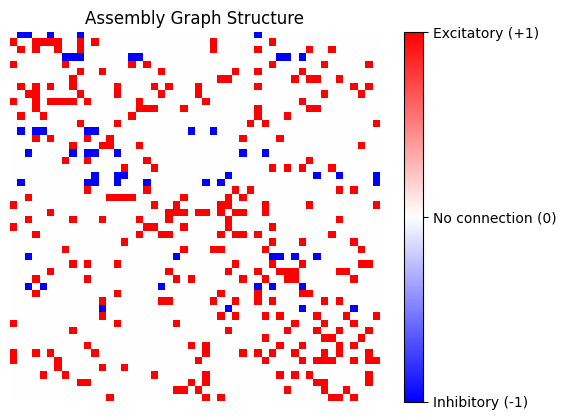

In [151]:
fig, ax = plt.subplots()
im = ax.imshow(connectivity_graph, cmap="bwr", vmin=-1, vmax=1)
cbar = plt.colorbar(im, ax=ax, ticks=[-1, 0, 1])
cbar.ax.set_yticklabels(["Inhibitory (-1)", "No connection (0)", "Excitatory (+1)"])
ax.set_title("Assembly Graph Structure")
ax.axis("off")
plt.show()

### Assign Synaptic Weights

We now convert the unweighted connectivity graph into a weighted graph, with inhibitory and excitatory synaptic strengths drawn from biologically realistic log-normal distributions.

We want to balance the total synaptic input to each neuron on average. Given that the log-normal distribution has expectation:

$$\mathbb{E}[X] = \exp\left(\mu + \frac{\sigma^2}{2}\right)$$

And we have roughly four times as many excitatory neurons as inhibitory neurons, we can approximately acheive balance by setting:

$$\mu_I = \mu_E + \log{4}$$

We then visualise this graph and check the distribution of input weights to all neurons is roughly balanced.

In [152]:
weights = weight_assigners.assign_weights_lognormal(
    connectivity_graph=connectivity_graph,
    neuron_types=neuron_types,
    E_mean=1.0,
    E_std=0.2,
    I_mean=2.39,
    I_std=0.2,
)

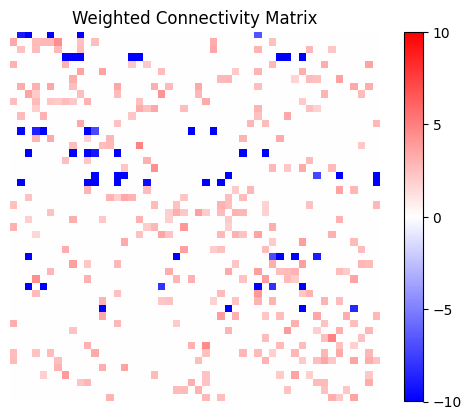

In [153]:
fig, ax = plt.subplots()
im = ax.imshow(weights, cmap="bwr", vmin=-10, vmax=10)
cbar = plt.colorbar(im, ax=ax, ticks=[-10, -5, 0, 5, 10])
ax.set_title("Weighted Connectivity Matrix")
ax.axis("off")
plt.show()

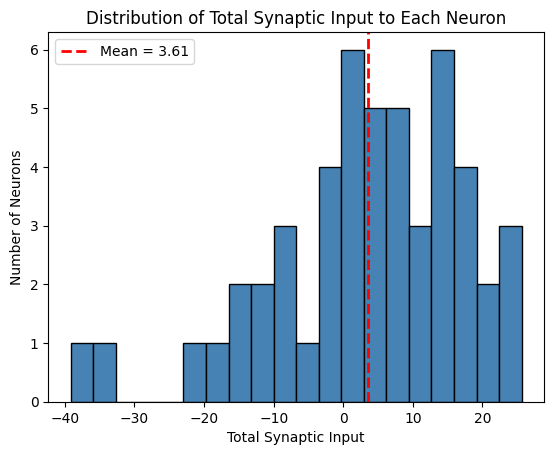

In [154]:
synaptic_inputs = weights.sum(axis=0)
mean_input = synaptic_inputs.mean()

fig, ax = plt.subplots()
ax.hist(synaptic_inputs, bins=20, color="steelblue", edgecolor="black")
ax.axvline(mean_input, color="red", linestyle="--", linewidth=2, label=f"Mean = {mean_input:.2f}")
ax.set_title("Distribution of Total Synaptic Input to Each Neuron")
ax.set_xlabel("Total Synaptic Input")
ax.set_ylabel("Number of Neurons")
ax.legend()
plt.show()

### Explore our network parameters

Before we can simulate a recurrent SNN with this weight matrix, we have to choose some further network parameters.

We load parameters adapted from [Meissner-Bernard et al. (2025)](https://doi.org/10.1016/j.celrep.2025.115330), which includes a combination of parameters measured in zebrafish Dp and some fit to match experimental network activity recordings.

In [155]:
params_df = pd.read_csv(repo_root / "parameters" / "zebrafish-dp-default.csv", comment='#')

print("Network Parameters (adapted from Meissner-Bernard et al. 2025)")
print("=" * 62)
display(params_df.style.set_properties(**{'text-align': 'left'}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'left')]}
]).hide(axis='index').format({'value': '{:.1f}'}))

Network Parameters (adapted from Meissner-Bernard et al. 2025)


parameter,symbol,value,unit,description
simulation_timestep,delta_t,1.0,ms,Time resolution of the simulation
membrane_time_constant_exc,tau_mem_exc,85.0,ms,Membrane time constant for excitatory neurons
membrane_time_constant_inh,tau_mem_inh,50.0,ms,Membrane time constant for inhibitory neurons
synaptic_time_constant_exc,tau_syn_exc,30.0,ms,Synaptic time constant for excitatory connections
synaptic_time_constant_inh,tau_syn_inh,10.0,ms,Synaptic time constant for inhibitory connections
membrane_resistance_exc,R_exc,740.7,MOhm,Membrane resistance for excitatory neurons
membrane_resistance_inh,R_inh,1111.1,MOhm,Membrane resistance for inhibitory neurons
resting_potential_exc,U_rest_exc,-60.0,mV,Resting membrane potential for excitatory neurons
resting_potential_inh,U_rest_inh,-60.0,mV,Resting membrane potential for inhibitory neurons
spike_threshold_exc,theta_exc,-38.0,mV,Spike threshold voltage for excitatory neurons


### Create network inputs

To run our network simulation, we additionally need to define feedforward inputs into the network.

To simulate baseline activity in the zebrafish olfactory bulb (OB), we simulate a population of 100 mitral cells, firing at constant rates of 6Hz, with spikes generated for each cell from a Poisson process. These cells then project randomly, with sparsity 0.1, to excitatory cells in our Dp network, with weights again generated from a log-normal distribution.

We also decide at this point to simulate the network activity for 10s.

In [156]:
duration = 10 # seconds
rate = 6.0  # Hz
mitral_cells = 100 # excitatory inputs

In [157]:
dt = params_df.set_index('symbol').loc['delta_t', 'value']*1e-3 # Convert ms to s
n_steps = int(duration / dt)
shape = (1, n_steps, mitral_cells)
p_spike = rate * dt
input_spikes = np.random.rand(*shape) < p_spike

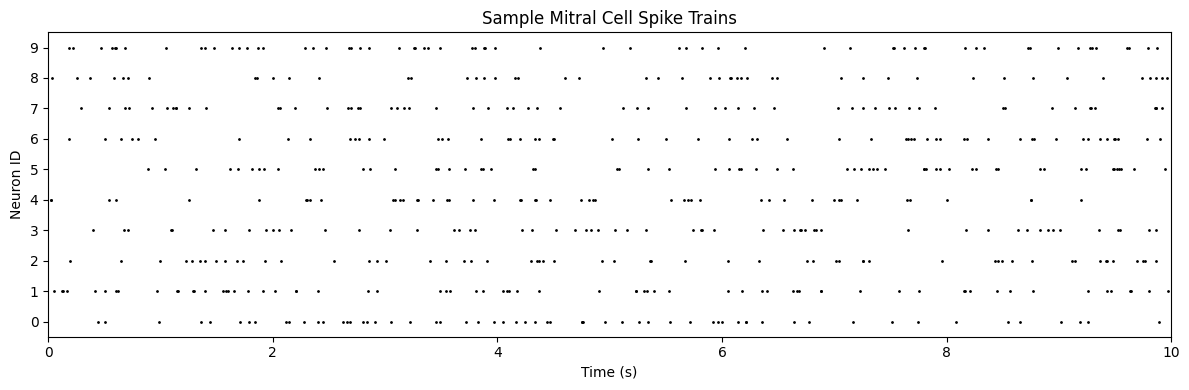

In [158]:
# Visualize the first 10 spike trains
fig, ax = plt.subplots(figsize=(12, 4))
time_window = int(10.0 / dt)
spike_times, neuron_ids = np.where(input_spikes[0, :time_window, :10])
ax.scatter(spike_times * dt, neuron_ids, s=1, color='black')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Neuron ID')
ax.set_title('Sample Mitral Cell Spike Trains')
ax.set_ylim(-0.5, 9.5)
ax.set_yticks(range(10))
ax.set_xlim(0, 10.0)
plt.tight_layout()
plt.show()

In [159]:
feedforward_connectivity_graph, _ = topology_generators.sparse_graph_generator(
    n_nodes=(mitral_cells, 50),
    p=0.1,
    p_exc=1.0,
)
# Set connections to inhibitory cells to zero (only connect to excitatory cells)
inhibitory_cells = np.where(neuron_types == -1)[0]
feedforward_connectivity_graph[:, inhibitory_cells] = 0

In [165]:
feedforward_weights = weight_assigners.assign_weights_lognormal(
    connectivity_graph=feedforward_connectivity_graph,
    neuron_types=np.ones(mitral_cells),
    E_mean=0.0,
    E_std=0.2,
    I_mean=2.39,
    I_std=0.2,
)

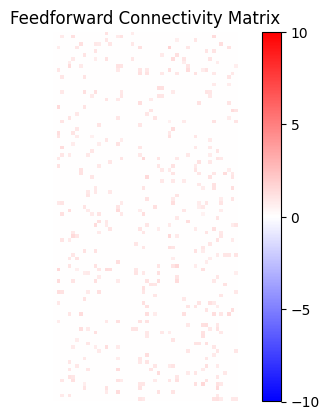

In [166]:
fig, ax = plt.subplots()
im = ax.imshow(feedforward_weights, cmap="bwr", vmin=-10, vmax=10)
cbar = plt.colorbar(im, ax=ax, ticks=[-10, -5, 0, 5, 10])
ax.set_title("Feedforward Connectivity Matrix")
ax.axis("off")
plt.show()

### Initialise network and run simulation

Here we finally initialise our current-based LIF recurrent network with the connectivity and inputs we have created. We simulate it for 10s and plot a sample of some of the spike trains it produces.

In [167]:
model = CurrentLIFNetwork(
    csv_path=repo_root / "parameters" / "zebrafish-dp-default.csv",
    neuron_types=neuron_types,
    recurrent_weights=weights,
    feedforward_weights=feedforward_weights,
)

model.initialise_parameters(
    E_weight=1e-3,
    I_weight=1e-3,
)

output_spikes, output_voltages, output_currents = model.forward(
    n_steps=n_steps,
    inputs=input_spikes,
)

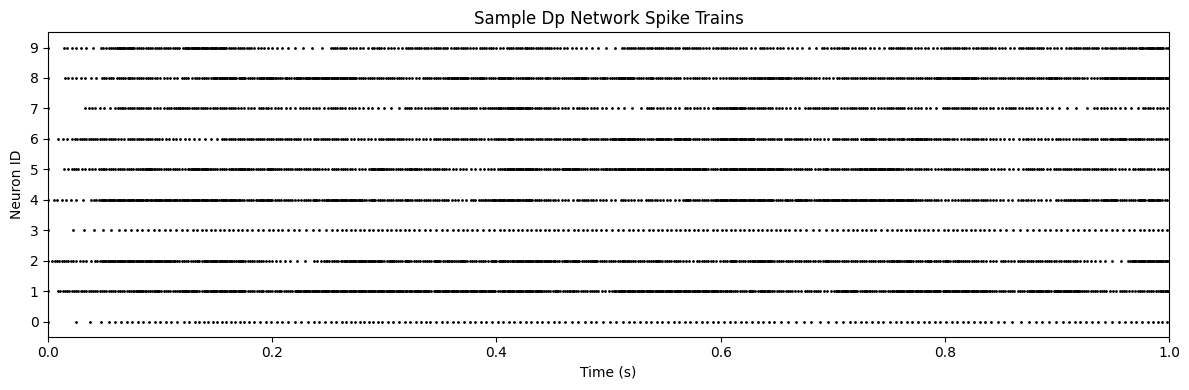

In [168]:
# Visualize the first 10 spike trains
fig, ax = plt.subplots(figsize=(12, 4))
time_window = int(1.0 / dt)
spike_times, neuron_ids = np.where(output_spikes[0, :time_window, :])
ax.scatter(spike_times * dt, neuron_ids, s=1, color='black')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Neuron ID')
ax.set_title('Sample Dp Network Spike Trains')
ax.set_ylim(-0.5, 9.5)
ax.set_yticks(range(10))
ax.set_xlim(0, 1.0)
plt.tight_layout()
plt.show()

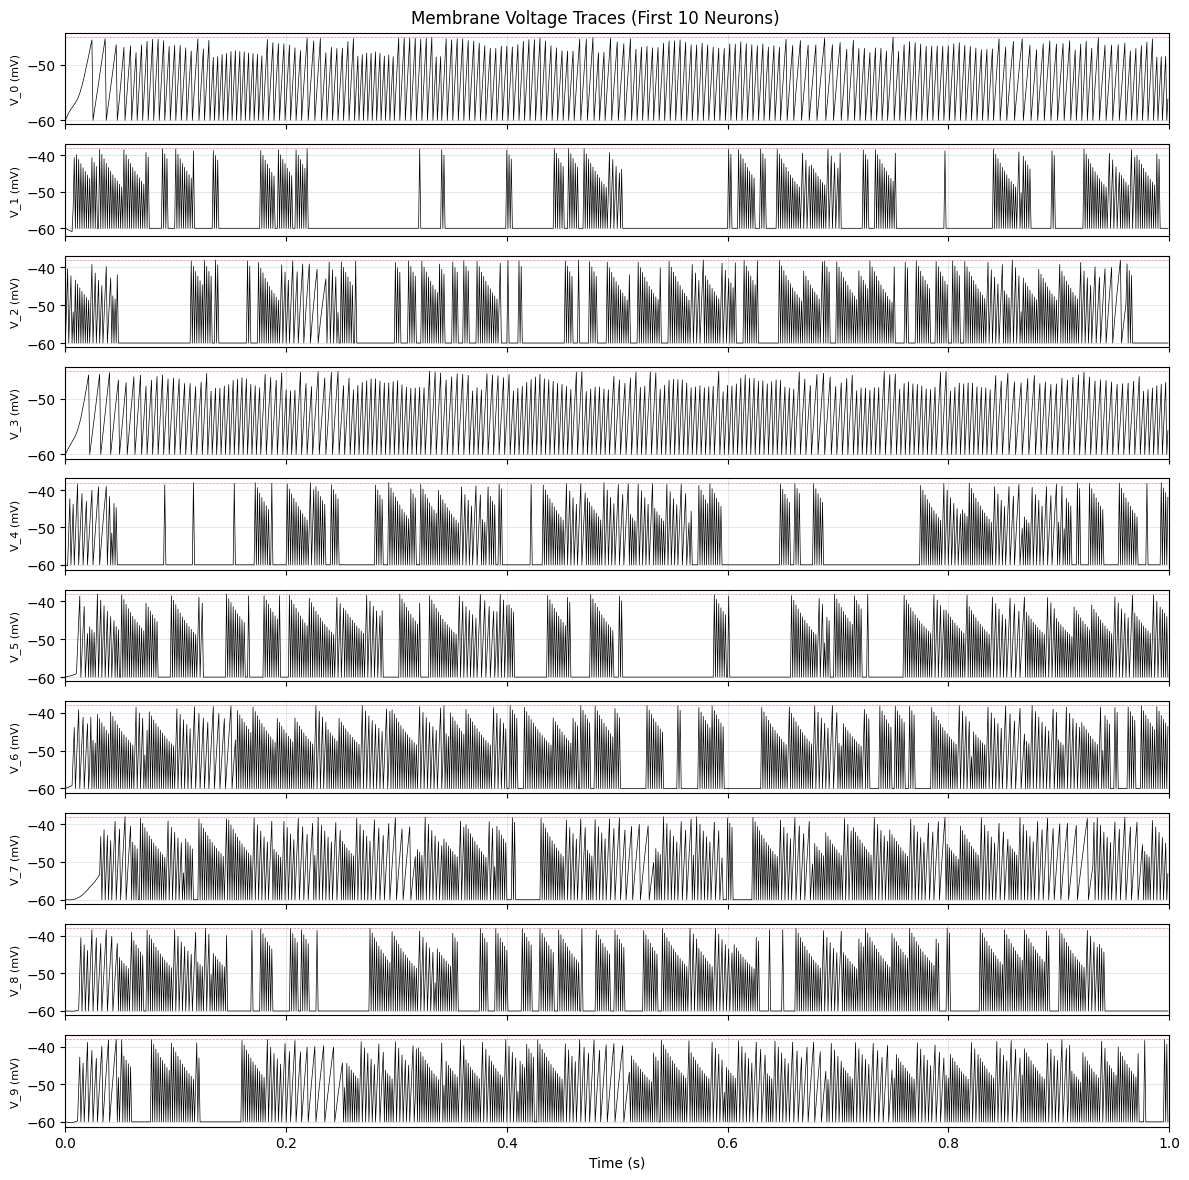

In [169]:
# Visualize membrane voltages for the first 10 neurons
fig, axes = plt.subplots(10, 1, figsize=(12, 12), sharex=True)
time_axis = np.arange(time_window) * dt

for neuron_id in range(10):
    axes[neuron_id].plot(time_axis, output_voltages[0, :time_window, neuron_id].detach().cpu().numpy(), 
                         linewidth=0.5, color='black')
    axes[neuron_id].set_ylabel(f'V_{neuron_id} (mV)', fontsize=8)
    axes[neuron_id].set_xlim(0, 1.0)
    axes[neuron_id].grid(True, alpha=0.3)
    
    # Add threshold line if available
    if neuron_types[neuron_id] == 1:
        axes[neuron_id].axhline(y=model.theta_exc.item(), color='red', linestyle='--', linewidth=0.5, alpha=0.5)
    else:
        axes[neuron_id].axhline(y=model.theta_inh.item(), color='red', linestyle='--', linewidth=0.5, alpha=0.5)

axes[-1].set_xlabel('Time (s)')
fig.suptitle('Membrane Voltage Traces (First 10 Neurons)', fontsize=12)
plt.tight_layout()
plt.show()